<a href="https://colab.research.google.com/github/AbdalrahmanAbdelaziz/DL-Project/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [16]:
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive

In [17]:
drive.mount('/content/drive')


zip_file_path = '/content/drive/My Drive/Colab Notebooks/datasets/archive.zip'
extract_path = '/content/dataset/'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


dataPath = os.path.join(extract_path, 'car_data/')
Train = os.path.join(dataPath, 'train')
Test = os.path.join(dataPath, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare Data

In [18]:
# Define constants
input_shape = (224, 224)
batch_size = 16
img_height, img_width = 224, 224
epochs = 30
lr = 1e-4

# Apply Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    Train,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    Test,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Number of classes
num_classes = len(train_generator.class_indices)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


# Build The Model

In [19]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
best_model_file = '/content/drive/My Drive/Colab Notebooks/models/DenseNet_Model.keras'
callbacks = [
    ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
]

In [20]:
# Train the model
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.0099 - loss: 5.5321
Epoch 1: val_accuracy improved from -inf to 0.09290, saving model to /content/drive/My Drive/Colab Notebooks/models/DenseNet_Model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 402s 475ms/step - accuracy: 0.0099 - loss: 5.5317 - val_accuracy: 0.0929 - val_loss: 4.6021 - learning_rate: 1.0000e-04
Epoch 2/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.0815 - loss: 4.5736
Epoch 2: val_accuracy improved from 0.09290 to 0.26651, saving model to /content/drive/My Drive/Colab Notebooks/models/DenseNet_Model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 205s 399ms/step - accuracy: 0.0815 - loss: 4.5732 - val_accuracy: 0.2665 - val_loss: 3.5924 - learning_rate: 1.0000e-04
Epoch 3/30
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2080 - loss: 3.6567
Epoch 3: val_accuracy improved from 0.26651 to 0.41500, saving model to /content/drive/My Drive/Colab Notebooks/models/DenseNet_Model.keras
509/509 ━━━━━━━━━━━━━━━━━━━━ 258

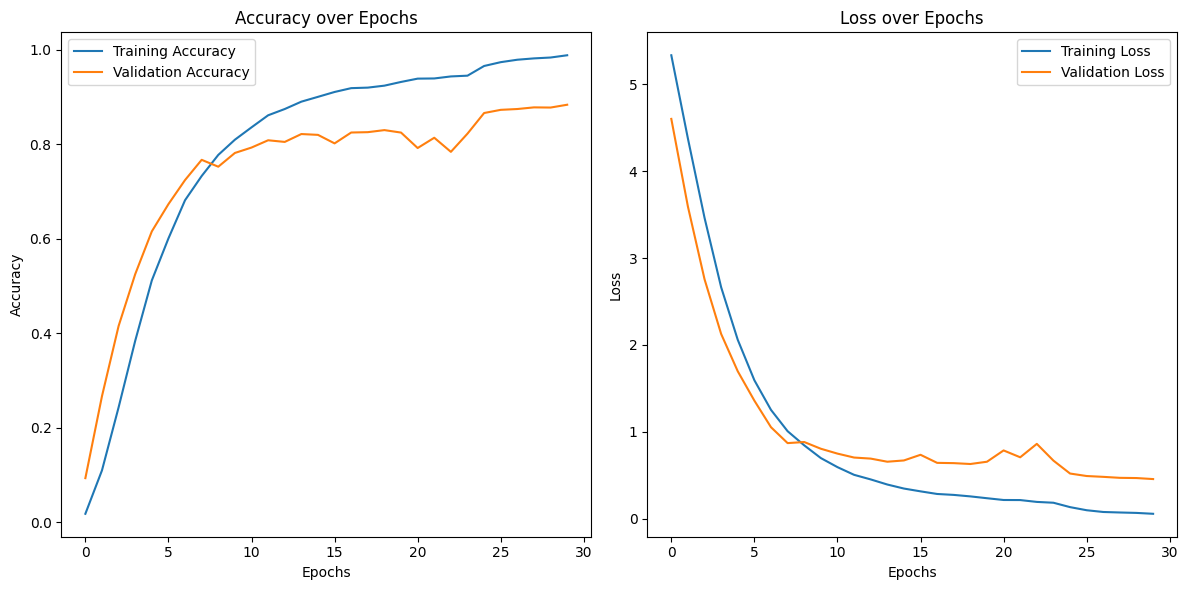

In [21]:
# Plot training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(hist)


# Load Saved Model

In [22]:
from tensorflow.keras.models import load_model


model = load_model('/content/drive/My Drive/Colab Notebooks/models/DenseNet_Model.keras')


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 196)                 │          50,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,891,726 (83.51 MB)

 Trainable params: 7,268,676 (27.73 MB)

 Non-trainable params: 85,696 (334.75 KB)

 Optimizer params: 14,537,354 (55.46 MB)

# Evaluation Metrics

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

503/503 ━━━━━━━━━━━━━━━━━━━━ 63s 105ms/step - accuracy: 0.8635 - loss: 0.5318
Test Accuracy: 0.88


In [25]:
# Generate classification report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


503/503 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.91      0.93      0.92        44
                             Acura Integra Type R 2001       0.90      1.00      0.95        44
                                   Acura RL Sedan 2012       0.71      0.84      0.77        32
                                   Acura TL Sedan 2012       0.78      0.98      0.87        43
                                  Acura TL Type-S 2008       0.98      0.95      0.96        42
                                  Acura TSX Sedan 2012       0.97      0.80      0.88        40
                              Acura ZDX Hatchback 2012       0.94      0.85      0.89        39
              Aston Martin V8 Vantage Convertible 2012       0.80      0.71      0.75        45
                    Aston Martin V8 Vantage Coupe 2012       0.75      0.73      0.74       

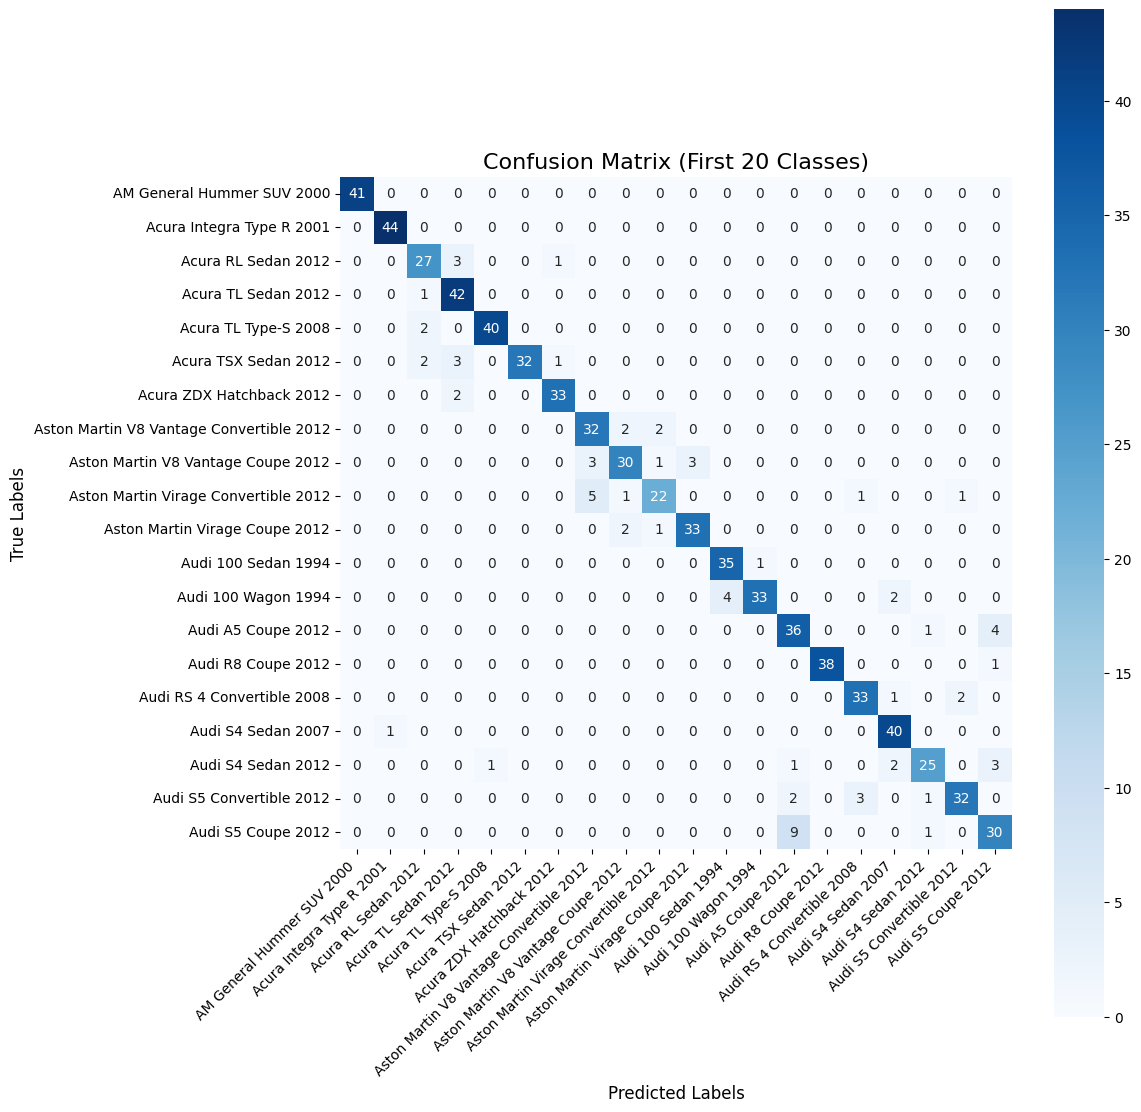

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels (mapping of class indices to class names)
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix (only display the first 20 classes if needed)
num_classes_to_display = 20
cm_subset = cm[:num_classes_to_display, :num_classes_to_display]
class_labels_subset = class_labels[:num_classes_to_display]

# Plot the confusion matrix for the first 20 classes
plt.figure(figsize=(12, 12))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels_subset,
    yticklabels=class_labels_subset,
    cbar=True,
    square=True
)

# Set titles and labels
plt.title("Confusion Matrix (First 20 Classes)", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


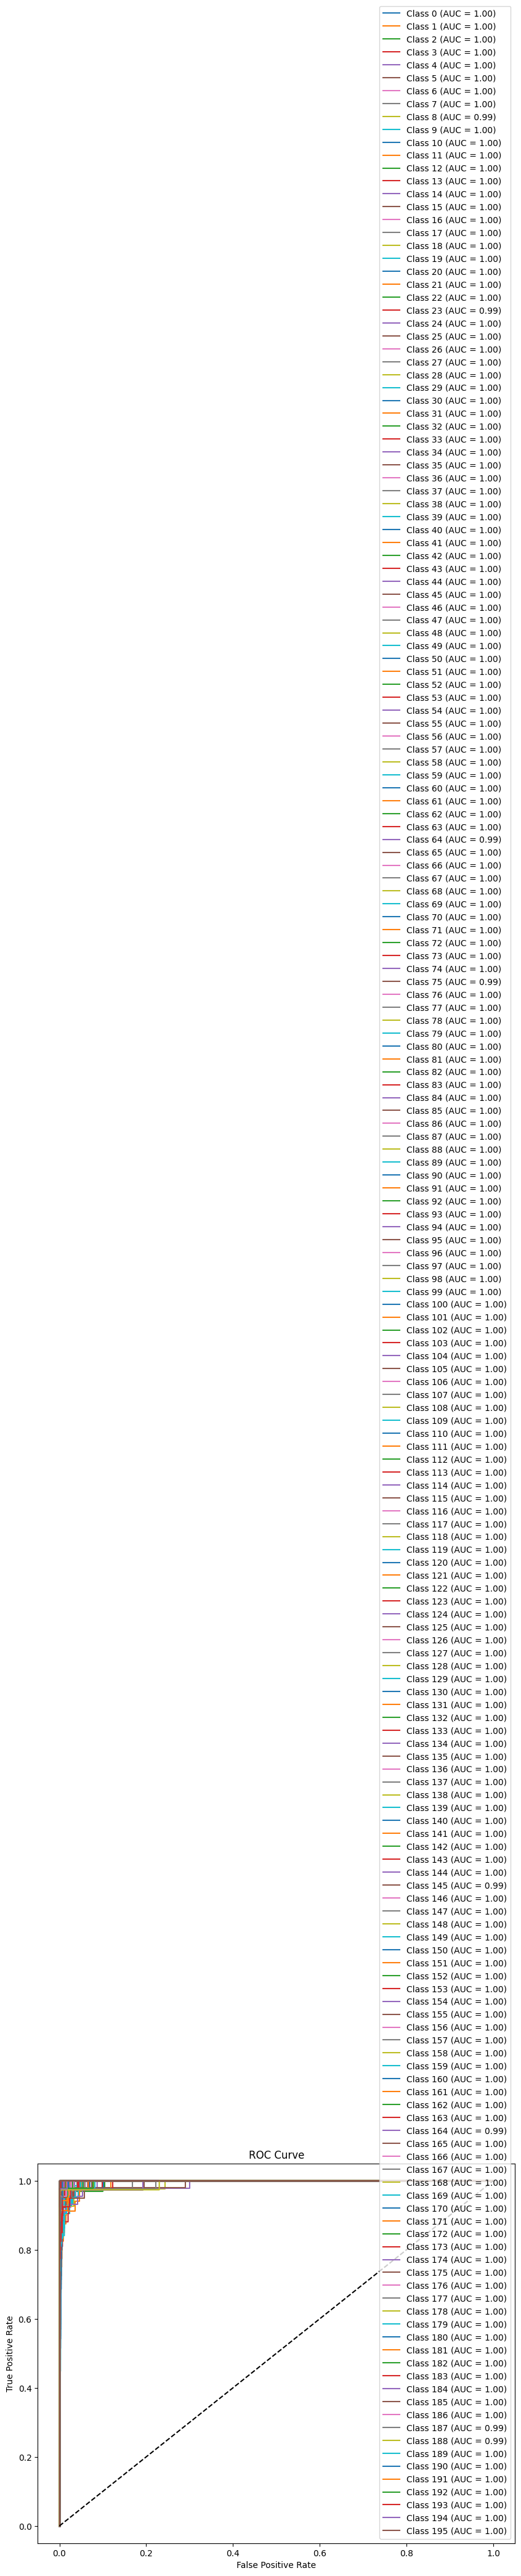

In [27]:
# Plot ROC-AUC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes)[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# Try The Model

In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array



In [29]:
test_image_path = '/content/drive/My Drive/Colab Notebooks/models/mm.jpeg'

preprocessed_image = preprocess_image(test_image_path)

# Predict the class
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability

# Map the index to the class label
class_labels = list(train_generator.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class: Mercedes-Benz C-Class Sedan 2012


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


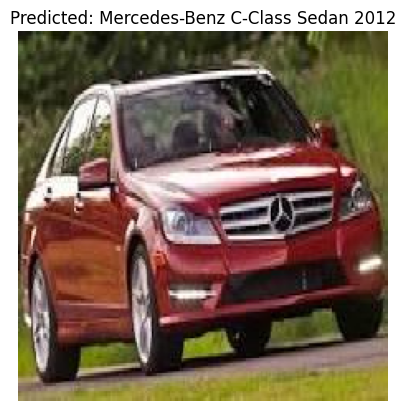

In [30]:
import matplotlib.pyplot as plt

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(img_height, img_width))
preprocessed_image = preprocess_image(test_image_path)

# Predict
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions)

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
